In [1]:
# reload
%load_ext autoreload
%autoreload 2

In [6]:
import numpy as np

import matplotlib.pyplot as plt

import sys
sys.path.append('../')
#import funPlots as fplot

import seaborn as sns
from scipy.stats import entropy

#fplot.master_format(ncols = 2, nrows = 1)

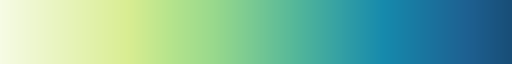

In [3]:
import matplotlib.patheffects as pe
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

colors = ["#F6FBE4", "#ECF6C9", "#E3F2AE", "#d9ed92", "#b5e48c", "#99d98c",
          "#76c893", "#52b69a", "#34a0a4", "#168aad", "#1a759f", "#1e6091", "#184e77"]
nodes = np.linspace(0, 1, len(colors))
cmap_SR = LinearSegmentedColormap.from_list("cmap_SR", list(zip(nodes, colors)))
cmap_SR.set_bad(color='w')
cmap_SR

In [4]:
from utils.simulation import *
from utils.mutual import (compute_mutual_information_from_trajectories, mutual_information_slowjumps, MC_underhood)
from utils.analytical import *

def get_default_params_system():
    ### Info system
    N = 2
    w = 2
    k = 1.1
    tau_ei = 1
    r = np.ones(N)
    
    return {'N': N, 'w': w, 'k': k, 'tau_ei': tau_ei, 'r': r}

/home/barzon/.local/lib/python3.8/site-packages/numba/core/errors.py:175: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)


In [7]:
data_folder = 'data/'

mutuals = np.load(data_folder+'mutual_importance_sampling.npy')
my_cmap_continuous = sns.color_palette('mako_r', as_cmap=True)

colors = ("#76c893", "#184e77")
labels = ('$E$', '$I$')

In [8]:
### Info input
M = 3
tau_h = 100
wup = 1 / tau_h
wdown = 2 / tau_h
delta_h = 2.5
hs = np.arange(M) * delta_h
hs = np.stack([hs, np.zeros(M)])

W = create_transition_matrix_star_graph(M, wup, wdown)

p_stat = np.array([wdown] + [wup] * (M-1))
p_stat = p_stat / p_stat.sum()

In [9]:
### Define grid params
kmin, kmax = 0., 5
wmin, wmax = 0.01, 10

nk, nw = int(2e2), int(2e2)

k_list, w_list = np.linspace(kmin, kmax, nw), np.linspace(wmin, wmax, nw)

Ws, Ks = np.meshgrid(w_list, k_list)

In [10]:
np.nanmin(mutuals), np.nanmax(mutuals)

(0.7464735023716894, 1.0430062884737181)

In [11]:
w = 10
mutual_line_10_logspace = np.load(data_folder+f'mutual_importance_sampling_fixedw{w}_logspace.npy')
k_list_10_logspace = np.load(data_folder+f'k_list_fixedw{w}_logspace.npy')
bounds_up_10_logspace = np.load(data_folder+f'bounds_up_fixedw{w}_logspace.npy')
bounds_down_10_logspace = np.load(data_folder+f'bounds_down_fixedw{w}_logspace.npy')

mutual_line_10 = np.load(data_folder+f'mutual_importance_sampling_fixedw{w}.npy')
k_list_10 = np.load(data_folder+f'k_list_fixedw{w}.npy')
bounds_up_10 = np.load(data_folder+f'bounds_up_fixedw{w}.npy')
bounds_down_10 = np.load(data_folder+f'bounds_down_fixedw{w}.npy')

w = 1.05
mutual_line_1_logspace = np.load(data_folder+f'mutual_importance_sampling_fixedw{w}_logspace.npy')
k_list_1_logspace = np.load(data_folder+f'k_list_fixedw{w}_logspace.npy')
bounds_up_1_logspace = np.load(data_folder+f'bounds_up_fixedw{w}_logspace.npy')
bounds_down_1_logspace = np.load(data_folder+f'bounds_down_fixedw{w}_logspace.npy')

mutual_line_1 = np.load(data_folder+f'mutual_importance_sampling_fixedw{w}.npy')
k_list_1 = np.load(data_folder+f'k_list_fixedw{w}.npy')
bounds_up_1 = np.load(data_folder+f'bounds_up_fixedw{w}.npy')
bounds_down_1 = np.load(data_folder+f'bounds_down_fixedw{w}.npy')

k_crit_10 = 1 - 1 / 10
k_crit_1 = 1 - 1 / 1.05

In [12]:
Hinput = entropy(p_stat)/np.log(2)
Hinput

1.5

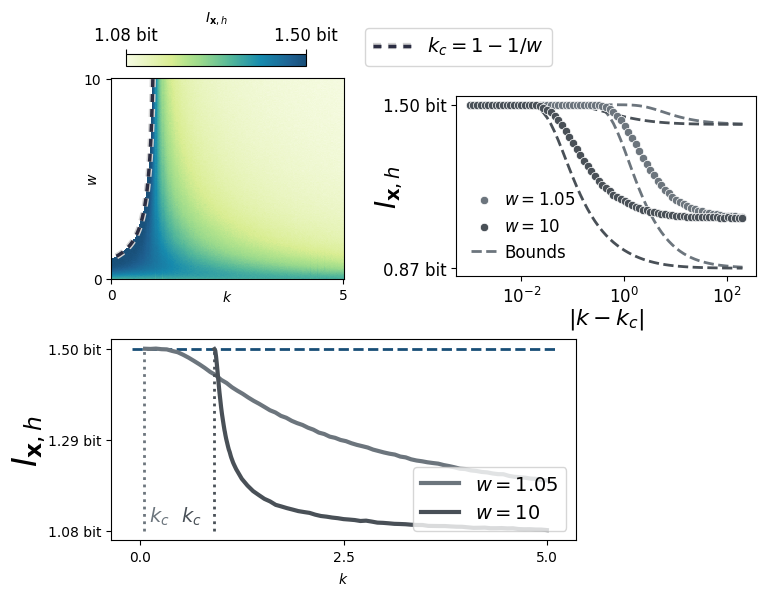

In [14]:
fig, axs = plt.subplot_mosaic([["CP", "."],
                               ["MI", "MI"]],
                               figsize = (6, 6),
                               gridspec_kw = {'height_ratios': [1,1]})
plt.subplots_adjust(hspace=0.3, wspace=0.)
axs["CP"].pcolor(Ks, Ws, mutuals.T/np.log(2), cmap=cmap_SR, rasterized = True, shading = 'auto')
axs["CP"].plot(1-1/w_list, w_list, ls = '--', color='#2b2d42', lw=2.5, label = "$k_c = 1 - 1/w$",
               path_effects=[pe.Stroke(linewidth=4.5, foreground='lightgray'), pe.Normal()],
               dashes=[2.3, 2])

axs["CP"].set_xlim(kmin,None)

axs["CP"].set_xlabel('$k$', labelpad = -10)
axs["CP"].set_ylabel('$w$', labelpad = -12)
axs["CP"].set_xticks([0, 5])
axs["CP"].set_yticks([0, 10])

axs["CP"].legend(fontsize = 14, bbox_to_anchor=(1.05, 1.3), loc='upper left')

cax = fig.add_axes([0.15, 0.9, 0.3, 0.02])
cbar = plt.colorbar(axs["CP"].collections[0], cax=cax, orientation='horizontal', label = r'$I_{\mathbf{x},h}$')
cax.xaxis.set_ticks_position('top')
cax.xaxis.set_label_position('top')

min_mutual = np.nanmin(mutuals)/np.log(2)
max_mutual = np.nanmax(mutuals)/np.log(2)

cbar.set_ticks([min_mutual , max_mutual])
cbar.set_ticklabels([f'{min_mutual:.2f} bit', f'{max_mutual:.2f} bit'], fontsize = 12)


axs["MI"].plot(k_list_1, mutual_line_1/np.log(2), color = "#6c757d", lw = 3, label = "$w = 1.05$")
axs["MI"].vlines(k_crit_1, 1.08, Hinput, color = "#6c757d", lw = 2, ls = 'dotted')
axs["MI"].text(0.1, 1.1, '$k_c$', color = '#6c757d', fontsize = 14)

axs["MI"].plot(k_list_10, mutual_line_10/np.log(2), color = "#495057", lw = 3, label = "$w = 10$")
axs["MI"].vlines(k_crit_10, 1.08, Hinput, color = "#495057", lw = 2, ls = 'dotted')
axs["MI"].text(0.5, 1.1, '$k_c$', color = '#495057', fontsize = 14)

axs["MI"].hlines(Hinput, -0.1, 5.1, color = '#184e77', ls = '--', lw = 2, zorder = -np.inf)

axs["MI"].set_xlabel('$k$', labelpad = 5)
axs["MI"].set_ylabel('$I_{\mathbf{x},h}$', labelpad = 0, fontsize = 24)

axs["MI"].set_xticks([0, 2.5, 5])
axs["MI"].set_yticks([1.08, 1.29, 1.5])
axs["MI"].set_yticklabels([f'{1.08:.2f} bit', f'{1.29:.2f} bit', f'{1.5:.2f} bit'])

axs["MI"].legend(fontsize = 14, loc = 'lower right')

ax_inset = fig.add_axes([0.7, 0.55, 0.5, 0.3])
ax_inset.scatter(k_list_1_logspace - k_crit_1, mutual_line_1_logspace/np.log(2), color = "#6c757d", lw = 0.5, ec = "w", label = "$w = 1.05$")
ax_inset.scatter(k_list_10_logspace - k_crit_10, mutual_line_10_logspace/np.log(2), color = "#495057", lw = 0.5, ec = "w", label = "$w = 10$")

ax_inset.plot(k_list_1_logspace - k_crit_1, bounds_up_1_logspace/np.log(2), color = "#6c757d", lw = 2, ls = '--', zorder = -np.inf, label = "Bounds")
ax_inset.plot(k_list_1_logspace - k_crit_1, bounds_down_1_logspace/np.log(2), color = "#6c757d", lw = 2, ls = '--', zorder = -np.inf)

ax_inset.plot(k_list_10_logspace - k_crit_10, bounds_up_10_logspace/np.log(2), color = "#495057", lw = 2, ls = '--', zorder = -np.inf)
ax_inset.plot(k_list_10_logspace - k_crit_10, bounds_down_10_logspace/np.log(2), color = "#495057", lw = 2, ls = '--', zorder = -np.inf)

ax_inset.legend(fontsize = 12, loc = 'lower left', handlelength = 1.5, handletextpad = 0.5, frameon = False)

ax_inset.tick_params(axis='both', which='major', labelsize=12)

ax_inset.set_xscale('log')
ax_inset.set_yticks([0.87, 1.5])
ax_inset.set_yticklabels([f'{0.87:.2f} bit', f'{1.5:.2f} bit'])
ax_inset.set_xlabel('$|k - k_c|$', labelpad = 0, fontsize = 16)
ax_inset.set_ylabel('$I_{\mathbf{x},h}$', labelpad = -16, fontsize = 20)
#fplot.restore_log_ticks(ax_inset.xaxis, 10)

#plt.savefig('figures/Figure2_draft.svg', dpi = 300, bbox_inches = 'tight')
plt.show()

In [15]:
plt.figure(figsize=(6,3))

lw = 1

plt.plot(k_list, mutuals[idx_w], c='k', lw=lw)
plt.plot(k_list, bounds_up, c=colors[0], ls='--', lw=lw, label=r'$I_{up}$', zorder=2)
plt.plot(k_list, bounds_down, c=colors[1], ls='--', lw=lw, label=r'$I_{down}$', zorder=2)

plt.axhline(entropy(p_stat), c='gray', ls='--', lw=lw, label=r'$H_{jumps}$', zorder=0)

plt.ylim(0.35, None)

plt.legend()
sns.despine()
plt.xlabel('k')
plt.ylabel(r'$I_{\mathbf{x},h}$')
plt.show()

NameError: name 'idx_w' is not defined

<Figure size 600x300 with 0 Axes>